## Default Packages

In [101]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Tokenization

In [927]:
import spacy

train = pd.read_csv('train.csv').dropna()
test = pd.read_csv('test.csv').dropna()

nlp = spacy.load("en_core_web_sm", exclude = ['parser', 'ner'])

def preprocess(text):
    doc = nlp(text)
    prep_text = [token.text.lower() for token in doc if token.text.isalpha()]
    return ' '.join(prep_text)

# Remember to replace "`" with "'" to let spacy tokenize correctly
tr = train['text'].apply(lambda x: preprocess(x.replace("`","'")))
ts = test['text'].apply(lambda x: preprocess(x.replace("`","'")))

# Below lines were required to save tokenized datasets
# pd.concat([ts, test['sentiment']], axis=1).to_csv('test_tokenized.csv', index = False)
# pd.concat([tr, train['sentiment']], axis=1).to_csv('train_tokenized.csv', index = False)

## Data

In [2]:
# Import data
train = pd.read_csv('train_tokenized.csv')
test = pd.read_csv('test_tokenized.csv')

# There maybe a few missing values that can be removed.
train = train.dropna()
test = test.dropna()

In [3]:
train.sentiment.value_counts()

neutral     11106
positive     8580
negative     7780
Name: sentiment, dtype: int64

In [340]:
train.shape

(27466, 2)

In [145]:
test.sentiment.value_counts()

neutral     1426
positive    1102
negative    1001
Name: sentiment, dtype: int64

In [341]:
test.shape

(3529, 2)

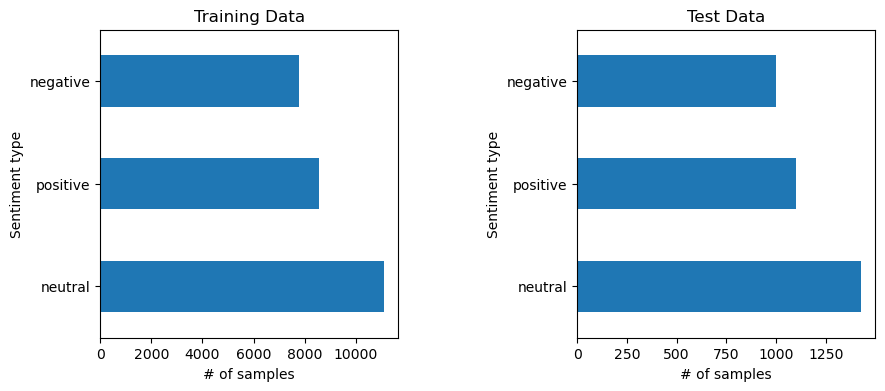

In [336]:
# Plotting distribution of classes in each of the datasets
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (10, 4), gridspec_kw={'hspace': 0.35,
                                  'wspace': 0.6,
                                  'height_ratios':[10]})
# Training
train.sentiment.value_counts().plot.barh(ax = ax[0])
ax[0].set_title('Training Data')
ax[0].set_xlabel('# of samples', fontdict={'fontsize':10})
ax[0].set_ylabel('Sentiment type', fontdict={'fontsize':10})

# Test
test.sentiment.value_counts().plot.barh(ax = ax[1])
ax[1].set_title('Test Data')
ax[1].set_xlabel('# of samples')
ax[1].set_ylabel('Sentiment type')

# Save figure to use in report
plt.savefig('data_distribution.png', dpi = 200)

## Train/Valid/Dev Split

In [131]:
from sklearn.model_selection import train_test_split

# Train
X, y = train['text'], train['sentiment']
# Test
X_test, y_test = test['text'], test['sentiment']

# Dividing X into train and validation sets for early stopping (in Neural Model)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.3, random_state=42)


## SVM Classifier with SGD Training

In [147]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report


# Design Pipeline
pipe = Pipeline([('vectorizer', TfidfVectorizer(ngram_range = (1, 2))), 
                 ('SGD', SGDClassifier(loss = 'modified_huber', 
                                       penalty = 'elasticnet',
                                       l1_ratio = 0.9,
                                       random_state = 42))])

# Above parameters for SGDClassifier were proven to be the best when implementing k-fold cross-validation (see below).

# Fit and Predict
pipe.fit(X, y)
y_train_pred = pipe.predict(X)
y_test_pred = pipe.predict(X_test)

print('Training Data Results:\n', classification_report(y, y_train_pred))
print('Test Data Results:\n', classification_report(y_test, y_test_pred))

Training Data Results:
               precision    recall  f1-score   support

    negative       0.82      0.65      0.72      7780
     neutral       0.68      0.82      0.74     11106
    positive       0.82      0.76      0.79      8580

    accuracy                           0.75     27466
   macro avg       0.77      0.74      0.75     27466
weighted avg       0.76      0.75      0.75     27466

Test Data Results:
               precision    recall  f1-score   support

    negative       0.73      0.68      0.71      1001
     neutral       0.67      0.72      0.69      1426
    positive       0.78      0.76      0.77      1102

    accuracy                           0.72      3529
   macro avg       0.73      0.72      0.73      3529
weighted avg       0.72      0.72      0.72      3529



## Grid Search of Parameters for SVM Classifier

In [140]:
from sklearn.model_selection import GridSearchCV
# set random seed
np.random.seed(42)


# Model
pipe = Pipeline([('vectorizer', TfidfVectorizer()), ('SGD', SGDClassifier())])

# Parameters
parameters = {'vectorizer__ngram_range':[(1, 1), (1, 2)],
             'SGD__loss':['huber', 'modified_huber', 'hinge', 'squared_hinge'],
             'SGD__l1_ratio':[0.2, 0.5, 0.9],
             'SGD__penalty':['l1', 'l2', 'elasticnet']}

# Grid Search Implementation
search = GridSearchCV(pipe, parameters, cv = 5, scoring = 'accuracy')
search.fit(X, y)

C:\Users\Public\anaconda3\envs\tm\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
C:\Users\Public\anaconda3\envs\tm\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
C:\Users\Public\anaconda3\envs\tm\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
C:\Users\Public\anaconda3\envs\tm\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
C:\Users\Public\anaconda

C:\Users\Public\anaconda3\envs\tm\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
C:\Users\Public\anaconda3\envs\tm\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
C:\Users\Public\anaconda3\envs\tm\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
C:\Users\Public\anaconda3\envs\tm\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
C:\Users\Public\anaconda

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                                       ('SGD', SGDClassifier())]),
             param_grid={'SGD__l1_ratio': [0.2, 0.5, 0.9],
                         'SGD__loss': ['huber', 'modified_huber', 'hinge',
                                       'squared_hinge'],
                         'SGD__penalty': ['l1', 'l2', 'elasticnet'],
                         'vectorizer__ngram_range': [(1, 1), (1, 2)]},
             scoring='accuracy')

In [142]:
# The best parameters after Grid Search
search.best_params_

{'SGD__l1_ratio': 0.9,
 'SGD__loss': 'modified_huber',
 'SGD__penalty': 'elasticnet',
 'vectorizer__ngram_range': (1, 2)}

## Data Pre-processing for Keras

In [7]:
from tensorflow.keras.layers import TextVectorization

# Find the length of the longest tweet to fix size of each sequence
max_sentence_length = X_train.apply(lambda x: len(x)).max()

# use TextVectorization Layer from Keras to build a vocabulary
text_vec = TextVectorization(output_mode = 'int', output_sequence_length = 142)
text_vec.adapt(X_train)

# get the whole learned vocabulary
vocabulary = text_vec.get_vocabulary()
# create index >> word type of vocabulary
indexed_vocabulary = dict(enumerate(vocabulary)) 

In [8]:
from sklearn.preprocessing import LabelEncoder

# Mapping each tweet into a list of indices (corresponding to the words in vocabulary)
X_train_encoded = text_vec(X_train).numpy()
X_valid_encoded = text_vec(X_valid).numpy()
X_test_encoded = text_vec(X_test).numpy()

# One-Hot Encoding of labels
label_encoder = LabelEncoder()

# Encoded Train labels
y_train_encoded = label_encoder.fit_transform(y_train)
y_train_encoded = tf.keras.utils.to_categorical(y_train_encoded)

# Encoded Validation Labels
y_valid_encoded = label_encoder.fit_transform(y_valid)
y_valid_encoded = tf.keras.utils.to_categorical(y_valid_encoded)

# Encoded Test Labels
y_test_encoded = label_encoder.fit_transform(y_test)
y_test_encoded = tf.keras.utils.to_categorical(y_test_encoded)

# label_encoder.classes_
# 0 - negative, 1 - neutral, 2 - positive

## LSTM trained Embeddings

In [148]:
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint

# Find the length of vocabulary
vocab_length = len(text_vec.get_vocabulary())

# Model architecture
model = Sequential([ # Note that in Embedding() output_dim = 100 because pre-trained embeddings will have the same size
                   Embedding(input_dim = vocab_length, output_dim = 100, mask_zero = True),
                   LSTM(64, activation = 'relu'),
                   Dense(64, activation='relu'),
                   Dense(3, activation='softmax')])

# Compilation parameters
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor = 'val_loss', patience = 3, mode = 'min')
save_best_model = ModelCheckpoint('lstm_trained_embd.keras', save_best_only = True)

In [149]:
model.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_16 (Embedding)    (None, None, 100)         1878400   
                                                                 
 lstm_16 (LSTM)              (None, 64)                42240     
                                                                 
 dense_31 (Dense)            (None, 64)                4160      
                                                                 
 dense_32 (Dense)            (None, 3)                 195       
                                                                 
Total params: 1,924,995
Trainable params: 1,924,995
Non-trainable params: 0
_________________________________________________________________


In [150]:
# Model Fit
history1 = model.fit(X_train_encoded, y_train_encoded,
                    epochs = 20,
                    validation_data = (X_valid_encoded, y_valid_encoded),
                    batch_size = 64, 
                    callbacks = [early_stopping, save_best_model])

Epoch 1/20
301/301 [==============================] - 31s 88ms/step - loss: 0.8673 - accuracy: 0.6018 - val_loss: 0.7148 - val_accuracy: 0.7028
Epoch 2/20
301/301 [==============================] - 25s 84ms/step - loss: 0.5600 - accuracy: 0.7792 - val_loss: 0.7230 - val_accuracy: 0.6994
Epoch 3/20
301/301 [==============================] - 25s 84ms/step - loss: 0.3833 - accuracy: 0.8581 - val_loss: 0.8282 - val_accuracy: 0.6891
Epoch 4/20
301/301 [==============================] - 26s 85ms/step - loss: 0.2784 - accuracy: 0.8999 - val_loss: 0.9486 - val_accuracy: 0.6716


In [152]:
from keras.models import load_model

# Load the best performing model
model = load_model('lstm_trained_embd.keras')
# Predict with loaded model
y_p = model.predict(X_test_encoded)
# Output evaluation metrics
print(classification_report(y_test_encoded.argmax(axis = 1), y_p.argmax(axis = 1)))

111/111 [==============================] - 3s 21ms/step
              precision    recall  f1-score   support

           0       0.73      0.64      0.68      1001
           1       0.64      0.74      0.68      1426
           2       0.79      0.72      0.76      1102

    accuracy                           0.71      3529
   macro avg       0.72      0.70      0.71      3529
weighted avg       0.71      0.71      0.71      3529



## Improting GloVe Pre-trained Embeddings

In [21]:
# Create a dictionary where each word and its embedding vector will be saved.
embedding_dict = {}

# Open GloVe file with words and embeddings
with open('glove.twitter.27B/glove.twitter.27B.100d.txt', encoding="utf8") as file:
    for line in file:
        # Split only words and embeddings in a given line by setting maxsplit = 1
        word, embeddings = line.split(maxsplit = 1)
        # convert an embedding vector from 'str' to 'f' format
        embeddings = np.fromstring(embeddings, dtype = 'f', sep = ' ')
        # save to dictionary
        embedding_dict[word] = embeddings

In [22]:
# Number of words with pre-trained embeddings
len(embedding_dict)

1193514

In [23]:
# Specify dimension of embedding vector
emb_dim = 100

# Create an empty embedding matrix
embedding_matrix = np.zeros(shape  = (vocab_length, emb_dim))

# For each index and word in vocabulary find its embedding vector from embedding dictionary (defined above)
for index, word in indexed_vocabulary.items():
    
    # If index is less than vocabulary size, extract embedding vector corresponding to the word under this index
    if index < vocab_length:
        embedding_vector = embedding_dict.get(word)
    
    # If None (the word not found in embedding dictionary), then it will be filled with zeros
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [343]:
print(f'Vocabulary size = {vocab_length}')

Vocabulary size = 18784


In [24]:
# For each word in vocabulary, its (100, 1) - dimensional embedding vector is found
embedding_matrix.shape

(18784, 100)

## LSTM with Pre-Trained Embeddings

In [153]:
from keras.initializers import Constant

# Model architecture
model = Sequential([
                   Embedding(input_dim = vocab_length, output_dim = emb_dim,
                             # Initialize embeddings with embedding matrix (from GloVe)
                             embeddings_initializer = Constant(embedding_matrix),
                             mask_zero = True,
                             trainable = False),
                   LSTM(64, activation = 'relu'),
                   Dense(64, activation='relu'),
                   Dense(3, activation='softmax')])

# Compilation parameters
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor = 'val_loss', patience = 3, mode = 'min')
save_best_model = ModelCheckpoint('lstm_pre_trained_embd.keras', save_best_only = True)

In [154]:
model.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_17 (Embedding)    (None, None, 100)         1878400   
                                                                 
 lstm_17 (LSTM)              (None, 64)                42240     
                                                                 
 dense_33 (Dense)            (None, 64)                4160      
                                                                 
 dense_34 (Dense)            (None, 3)                 195       
                                                                 
Total params: 1,924,995
Trainable params: 46,595
Non-trainable params: 1,878,400
_________________________________________________________________


In [155]:
# Model Fit
history2 = model.fit(X_train_encoded, y_train_encoded,
                    epochs = 20,
                    validation_data = (X_valid_encoded, y_valid_encoded),
                    batch_size = 64, 
                    callbacks = [early_stopping, save_best_model])


Epoch 1/20
301/301 [==============================] - 30s 88ms/step - loss: 0.8258 - accuracy: 0.6218 - val_loss: 0.7156 - val_accuracy: 0.6965
Epoch 2/20
301/301 [==============================] - 26s 86ms/step - loss: 0.6733 - accuracy: 0.7116 - val_loss: 0.6701 - val_accuracy: 0.7181
Epoch 3/20
301/301 [==============================] - 27s 89ms/step - loss: 0.6249 - accuracy: 0.7366 - val_loss: 0.6573 - val_accuracy: 0.7250
Epoch 4/20
301/301 [==============================] - 27s 91ms/step - loss: 0.5911 - accuracy: 0.7522 - val_loss: 0.6474 - val_accuracy: 0.7337
Epoch 5/20
301/301 [==============================] - 25s 84ms/step - loss: 0.5622 - accuracy: 0.7642 - val_loss: 0.6494 - val_accuracy: 0.7313
Epoch 6/20
301/301 [==============================] - 24s 81ms/step - loss: 0.5330 - accuracy: 0.7792 - val_loss: 0.6538 - val_accuracy: 0.7367
Epoch 7/20
301/301 [==============================] - 25s 84ms/step - loss: 0.5048 - accuracy: 0.7930 - val_loss: 0.6628 - val_accuracy:

In [156]:
# Load the best performing model
model = load_model('lstm_pre_trained_embd.keras')
# Predict with loaded model
y_p = model.predict(X_test_encoded)
# Output evaluation metrics
print(classification_report(y_test_encoded.argmax(axis = 1), y_p.argmax(axis = 1)))

111/111 [==============================] - 3s 20ms/step
              precision    recall  f1-score   support

           0       0.72      0.69      0.70      1001
           1       0.68      0.73      0.70      1426
           2       0.80      0.77      0.79      1102

    accuracy                           0.73      3529
   macro avg       0.74      0.73      0.73      3529
weighted avg       0.73      0.73      0.73      3529



## LSTM with Re-Trained Embeddings

In [157]:
# Model architecture
model = Sequential([
                   Embedding(input_dim = vocab_length, output_dim = emb_dim,
                             # Initialize embeddings with embedding matrix (from GloVe)
                             embeddings_initializer = Constant(embedding_matrix),
                             mask_zero = True,
                             trainable = True), # Set trainable = True, to re-train GloVe embeddings
                   LSTM(64, activation = 'relu'),
                   Dense(64, activation='relu'),
                   Dense(3, activation='softmax')])

# Compilation Parameters
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor = 'val_loss', patience = 3, mode = 'min')
save_best_model = ModelCheckpoint('lstm_re_trained_embd.keras', save_best_only = True)

In [158]:
model.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_18 (Embedding)    (None, None, 100)         1878400   
                                                                 
 lstm_18 (LSTM)              (None, 64)                42240     
                                                                 
 dense_35 (Dense)            (None, 64)                4160      
                                                                 
 dense_36 (Dense)            (None, 3)                 195       
                                                                 
Total params: 1,924,995
Trainable params: 1,924,995
Non-trainable params: 0
_________________________________________________________________


In [159]:
# Model Fit
history3 = model.fit(X_train_encoded, y_train_encoded,
                    epochs = 20,
                    validation_data = (X_valid_encoded, y_valid_encoded),
                    batch_size = 64, 
                    callbacks = [early_stopping, save_best_model])


Epoch 1/20
301/301 [==============================] - 38s 110ms/step - loss: 0.7938 - accuracy: 0.6430 - val_loss: 0.6722 - val_accuracy: 0.7189
Epoch 2/20
301/301 [==============================] - 33s 108ms/step - loss: 0.5864 - accuracy: 0.7581 - val_loss: 0.6297 - val_accuracy: 0.7436
Epoch 3/20
301/301 [==============================] - 31s 102ms/step - loss: 0.4809 - accuracy: 0.8105 - val_loss: 0.6504 - val_accuracy: 0.7362
Epoch 4/20
301/301 [==============================] - 30s 101ms/step - loss: 0.3780 - accuracy: 0.8563 - val_loss: 0.7126 - val_accuracy: 0.7322
Epoch 5/20
301/301 [==============================] - 31s 103ms/step - loss: 0.3219 - accuracy: 0.8865 - val_loss: 0.7857 - val_accuracy: 0.7232


In [160]:
# Load the best performing model
model = load_model('lstm_re_trained_embd.keras')
# Predict with loaded model
y_p = model.predict(X_test_encoded)
# Output evaluation metrics
print(classification_report(y_test_encoded.argmax(axis = 1), y_p.argmax(axis = 1)))

111/111 [==============================] - 3s 21ms/step
              precision    recall  f1-score   support

           0       0.76      0.70      0.73      1001
           1       0.70      0.75      0.72      1426
           2       0.81      0.78      0.80      1102

    accuracy                           0.75      3529
   macro avg       0.75      0.75      0.75      3529
weighted avg       0.75      0.75      0.75      3529



## Plotting Training and Validation Errors of Three Neural Models

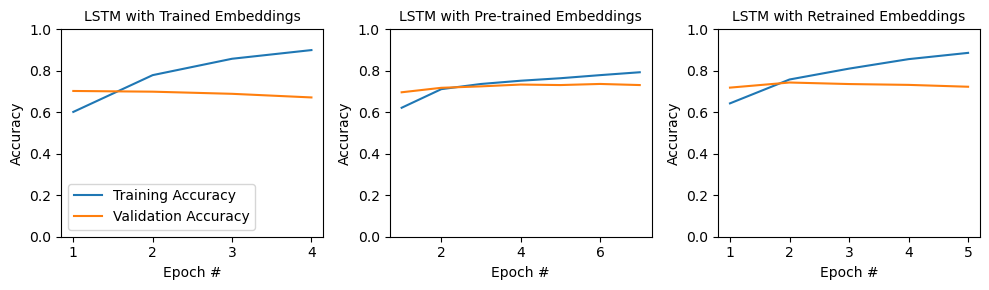

In [339]:
epoch1 = range(1, len(history1.history['accuracy']) + 1)
epoch2 = range(1, len(history2.history['accuracy']) + 1)
epoch3 = range(1, len(history3.history['accuracy']) + 1)

fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize = (10, 3))

# Trained Model
ax[0].plot(epoch1, history1.history['accuracy'])
ax[0].plot(epoch1, history1.history['val_accuracy'])
ax[0].set_ylim(0, 1) 
ax[0].set_xlabel('Epoch #')
ax[0].set_ylabel('Accuracy')
ax[0].set_title('LSTM with Trained Embeddings', fontdict = {'fontsize':10})
ax[0].legend(['Training Accuracy', 'Validation Accuracy'])

# Pre-trained Model
ax[1].plot(epoch2, history2.history['accuracy'])
ax[1].plot(epoch2, history2.history['val_accuracy'])
ax[1].set_ylim(0, 1)
ax[1].set_xlabel('Epoch #')
ax[1].set_ylabel('Accuracy')
ax[1].set_title('LSTM with Pre-trained Embeddings', fontdict = {'fontsize':10})

# Retrained Model
ax[2].plot(epoch, history3.history['accuracy'])
ax[2].plot(epoch, history3.history['val_accuracy'])
ax[2].set_ylim(0, 1)
ax[2].set_xlabel('Epoch #')
ax[2].set_ylabel('Accuracy')
ax[2].set_title('LSTM with Retrained Embeddings', fontdict = {'fontsize':10})

plt.tight_layout()
plt.savefig('performance_comparison.png', dpi = 200)

## Out-of-hand Sentiment Analysis

### Retrained LSTM

In [233]:
tweet = text_vec('I became stronger after going through many struggles').numpy().reshape(1,142)
# 0 - negative, 1 - neutral, 2 - positive
model.predict(tweet).round(3)

1/1 [==============================] - 0s 25ms/step


array([[0.544, 0.382, 0.074]], dtype=float32)

1. had a bad day -[0.856, 0.13 , 0.014]  
2. had so bad day - [0.889, 0.099, 0.013]  
3. had a good day - [0.028, 0.07 , 0.903]  
4. had so good day - [0.05 , 0.086, 0.863]  
5. had sooo good day - [0.033, 0.048, 0.919]  
6. What is the meaning of life? - [0.143, 0.765, 0.092]    
7. Why this world is sometimes so hard to love - [0.29 , 0.332, 0.378]  
8. I am greedy for knowledge - [0.616, 0.326, 0.057]  
9. I became stronger after going through many struggles - [0.544, 0.382, 0.074]

### SVM Classifier

In [245]:
pipe.predict_proba(pd.Series(['I am greedy for knowledge'])).round(3)

array([[0.22 , 0.568, 0.212]])

In [247]:
pipe.predict_proba(pd.Series(['I became stronger after going through many struggles'])).round(3)

array([[0.175, 0.685, 0.14 ]])